In [200]:
import warnings

import numpy as np
import pandas as pd
import torch
warnings.filterwarnings('ignore')

# 气温预测
这里使用到的数据是kaggle上的数据 <https://www.kaggle.com/datasets/ns0720/tempscsv>


In [201]:
features = pd.read_csv("../../data/temps.csv")
features.head()


,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2019,1,1,Fri,45,45,45.6,45,29
1,2019,1,2,Sat,44,45,45.7,44,61
2,2019,1,3,Sun,45,44,45.8,41,56
3,2019,1,4,Mon,44,41,45.9,40,53
4,2019,1,5,Tues,41,40,46.0,44,41


在数据表中:
- year,moth,day,week分别表示的具体的时间
- temp_2：前天的最高温度值
- temp_1：昨天的最高温度值
- average：在历史中，每年这一天的平均最高温度值
- actual：标签值，当天的真实最高温度
- friend: 朋友猜测的可能性, 过滤掉

In [202]:
print('数据维度:',features.shape) # 348 行 9 列

数据维度: (348, 9)


In [203]:
import datetime

# 进行数据处理
year = features['year']
month = features['month']
day = features['day']

dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(year,month,day)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]
dates[:5]

[datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 1, 2, 0, 0),
 datetime.datetime(2019, 1, 3, 0, 0),
 datetime.datetime(2019, 1, 4, 0, 0),
 datetime.datetime(2019, 1, 5, 0, 0)]

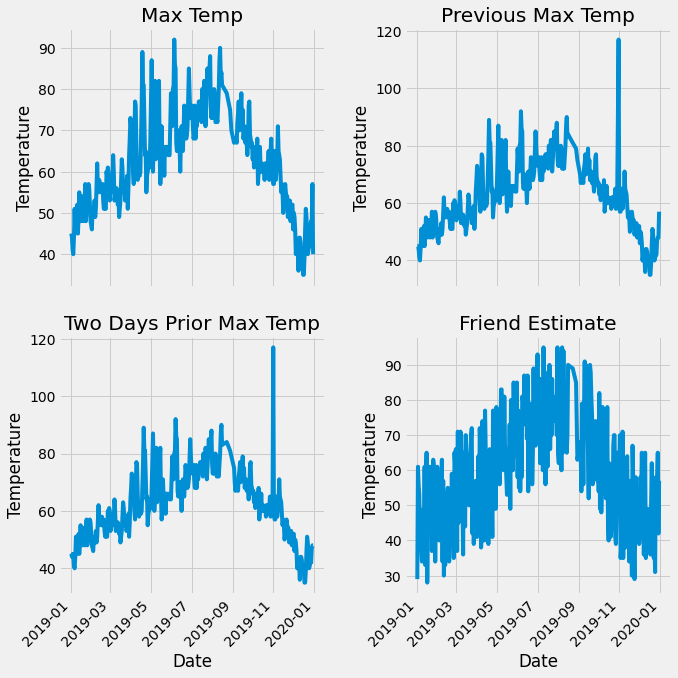

In [204]:
# 准备绘图, 指定绘图风格
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')
#tight_layout会自动调整子图参数,使之填充整个图像区域
plt.tight_layout(pad=2)


In [205]:
# 独热编码，将周（字符串）转化成编码的形式
# 简单来讲就是 将所有的可能性列出来, 有的话就是0,没有的话就是1的一个列表
# pd.get_dummies 会将所有不是数值的属性变为one hot编码. 
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2019,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2019,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2019,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2019,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2019,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [206]:
# 标签, 获取所有的y值
labels = np.array(features['actual'])

# 删除标签, drop默认删除行, 需要用axis=1来标识删除的是列
features = features.drop('actual', axis=1)

# 将名字单独保存一下
feature_list = list(features.columns)
feature_list

['year',
 'month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'friend',
 'week_Fri',
 'week_Mon',
 'week_Sat',
 'week_Sun',
 'week_Thurs',
 'week_Tues',
 'week_Wed']

In [207]:
# 转换成合适的格式, 将pandas的dataframe转换成ndarray的格式
features = np.array(features)
features.shape

(348, 14)

特征工程, 使用sklearn进行标准化操作

In [208]:
## 特征工程
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)
input_features[0] # 标准化的输出是ndarray格式

array([ 0.        , -1.5678393 , -1.65682171, -1.45311448, -1.46252836,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

构建神经网络模型

In [209]:
x=torch.tensor(input_features, dtype=float)
y=torch.tensor(labels, dtype=float)

# 权重参数初始化
# 构建神经网络模型所需要的参数
# 我们得到的数据维度是348x14的矩阵. 因此第一次乘积需要的矩阵则是14xN的矩阵才可以相乘. 
# 这里使用的是14x128最终得到一个128维度的向量进行下一步计算.
# 这里并不是用两个矩阵相乘, 而是每一次就调用14个数字然后生成128的矩阵, 这里的层不是计算的节点, 而是链接的层. 
# 因此就是14个源节点加上128个目标节点, 总共14*128个权重, 因为是全连接
# 而下一个biases就是偏置函数. 偏置函数就是sigmod那些所需要的初始theta
# 注意这里的梯度都是true,因为反向传播需要正确的梯度
weights = torch.randn((14,128),dtype=float,requires_grad=True)
biases = torch.randn(128,dtype=float,requires_grad=True)
weights2 = torch.randn((128,1),dtype=float,requires_grad=True) # 输出一个值
biases2 = torch.randn(1,dtype=float,requires_grad=True)

# 学习率, 注意 交大的学习率会使模型loss发散
learning_rate=0.001
losses=[]

torch存在两个操作
- torch.mul(a, b)是矩阵a和b**对应位**相乘，比如a的维度是(1, 2)，b的维度是(1, 2)，返回的仍是(1, 2)的矩阵
- torch.mm(a, b)是矩阵a和b**矩阵**相乘，比如a的维度是(1, 2)，b的维度是(2, 3)，返回的就是(1, 3)的矩阵

In [210]:
# 开始计算, 迭代1000次
for i in range(1000):
    # 计算隐藏层. 
    # 这里的mm()是矩阵乘法的意思, 最终得到一个 [348, 128]的矩阵.
    # 然后通过加法加上偏置函数, 也就是点相加, 最终还是一个128维度的数据.
    # 偏置函数就是那个 aX+b 里面的 'b', 那个常数
    hidden = x.mm(weights) + biases 
    # 让当前层进行relu的激活函数
    hidden = torch.relu(hidden)
    # 预测结果
    # 同样适用矩阵乘法. 最终得到结果也是加上这个偏置函数. 
    # 最终得到 348*1的矩阵
    predictions = hidden.mm(weights2) + biases2
    # 计算损失值
    # 这里使用简单的平方平均数的方法, ("**"就是几次方的意思)
    # 这里对所有的y进行均方误差计算
    loss = torch.mean((predictions-y) ** 2)
    losses.append(loss.data.numpy()) # 将损失值转换为numpy然后存入结果中
    
    # 打印
    if i % 100 == 0:
        print("loss:",loss)

    # 向后传播, 逆向求偏导
    loss.backward()

    # 更新梯度参数, 这里是减去梯度值, 记得加减号, 具体的逻辑查看markdown笔记
    weights.data.add_( - learning_rate * weights.grad.data)
    biases.data.add_( - learning_rate * biases.grad.data)
    weights2.data.add_( - learning_rate * weights2.grad.data)
    biases2.data.add_( - learning_rate * biases2.grad.data)

    # 更新结束以后grad清零
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss: tensor(8434.4618, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(152.4848, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(146.1411, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.8534, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.6452, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.8752, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.3523, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.9662, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.6770, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.4502, dtype=torch.float64, grad_fn=<MeanBackward0>)
